# Distribution des naissances dans le temps - essai avec la population du Conseil national

Dans ce carnet est proposée une analyse de la distribution dans le temps des années de naissance de la population retenue, et la mise en évidence de générations.

On met aussi en évidence l'évolution dans le temps des genres

In [8]:
### Librairie à installer dans l'environnement conda
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("Les imports se sont bien passés")

Les imports se sont bien passés


In [9]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile

print("Le deuxième batch d'imports a fonctionné")

Le deuxième batch d'imports a fonctionné


In [10]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
# sys.path.insert(0, '../..')


import sparql_functions as spqf

print("ca fonctionne")

ca fonctionne


## Se connecter à la base de données

In [11]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
cn = sql.connect('../../data/conseil_national_import.db')
cn

# allez chercher les tables dans la base de données

In [12]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
cn = sql.connect('../../data/conseil_national_import.db')
cn

In [13]:
qr = """
SELECT wp.id, wp.personne_uri, wp.nom_prenom as nom_prenom, wg.genre_uri,
 max(wp.annee_naissance) AS annee_naissance,
   max(wg.genre_code) AS genre
FROM 
    wdt_personnes wp
JOIN 
    wdt_genre wg ON wp.fk_genre_id = wg.id

GROUP BY 
    wp.id, 
    wp.personne_uri, 
    wp.nom_prenom, 
    wg.genre_uri;
"""

In [14]:
### Vérifier que les données ont été importées correctement
cur = cn.cursor()
l = cur.execute(qr).fetchall()
print(len(l))
l[:3]

885


[(0,
  'http://www.wikidata.org/entity/Q120229',
  'Robert Tobler',
  'http://www.wikidata.org/entity/Q6581097',
  1901,
  'M'),
 (6,
  'http://www.wikidata.org/entity/Q1579473',
  'Hans Fischer',
  'http://www.wikidata.org/entity/Q6581097',
  1901,
  'M'),
 (7,
  'http://www.wikidata.org/entity/Q1447990',
  'Franz Landolt',
  'http://www.wikidata.org/entity/Q6581097',
  1901,
  'M')]

## Créer un DataFrame à partir de la requête

In [15]:
### On transforme la liste en DataFrame
df_p = pd.DataFrame(l, columns=['id', 'personne_uri', 'nom_prenom', 'genre_uri', 'annee_naissance', 'genre_code'],)
df_p = df_p.set_index('id',drop=True)
df_p.head()

,personne_uri,nom_prenom,genre_uri,annee_naissance,genre_code
id,,,,,
0,http://www.wikidata.org/entity/Q120229,Robert Tobler,http://www.wikidata.org/entity/Q6581097,1901,M
6,http://www.wikidata.org/entity/Q1579473,Hans Fischer,http://www.wikidata.org/entity/Q6581097,1901,M
7,http://www.wikidata.org/entity/Q1447990,Franz Landolt,http://www.wikidata.org/entity/Q6581097,1901,M
8,http://www.wikidata.org/entity/Q2501257,Urs Dietschi,http://www.wikidata.org/entity/Q6581097,1901,M
9,http://www.wikidata.org/entity/Q1758783,Paul Schib,http://www.wikidata.org/entity/Q6581097,1901,M


In [16]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 885 entries, 0 to 1122
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   personne_uri     885 non-null    object
 1   nom_prenom       885 non-null    object
 2   genre_uri        885 non-null    object
 3   annee_naissance  885 non-null    int64 
 4   genre_code       885 non-null    object
dtypes: int64(1), object(4)
memory usage: 41.5+ KB


### Vérifier les genres présents directement sur la base de données

La requête suivante sera exécutée directement sur la base de données.

Le résultat sera affiché dans le carnet Jupyter. On peut préparer les requêtes SQL directement dans un logiciel comme DBeaver, puis les exécuter depuis un carnet Jupyter pour récupérer le résultat

In [17]:
query = """
SELECT genre_uri, count(*) as eff
FROM wdt_genre
GROUP BY genre_uri
ORDER BY eff DESC"""

In [18]:
cur = cn.cursor()

In [19]:
res = cur.execute(query)

In [20]:
res.fetchall()

[('http://www.wikidata.org/entity/Q6581097', 1),
 ('http://www.wikidata.org/entity/Q6581072', 1)]

## Effectifs par année

In [21]:
### On inspecte les valeurs de la colonne 'annee_naissance' 
# et on observe que le type de données est 'object', ici texte
df_p['annee_naissance'].info()

<class 'pandas.core.series.Series'>
Index: 885 entries, 0 to 1122
Series name: annee_naissance
Non-Null Count  Dtype
--------------  -----
885 non-null    int64
dtypes: int64(1)
memory usage: 13.8 KB


In [22]:
### On transforme en DataFrame le résultat du regroupement par année
# noter qu'un ajoute un filtre pour que l'année maximale de naissance soit 2000
years_count = pd.DataFrame(df_p[df_p['annee_naissance'] < 2001].groupby('annee_naissance').size())\
                .reset_index(drop=False)
years_count.columns=['year','effectif']
years_count

,year,effectif
0,1901,11
1,1902,7
2,1903,4
3,1904,5
4,1905,6
...,...,...
87,1989,2
88,1990,2
89,1991,1
90,1992,2


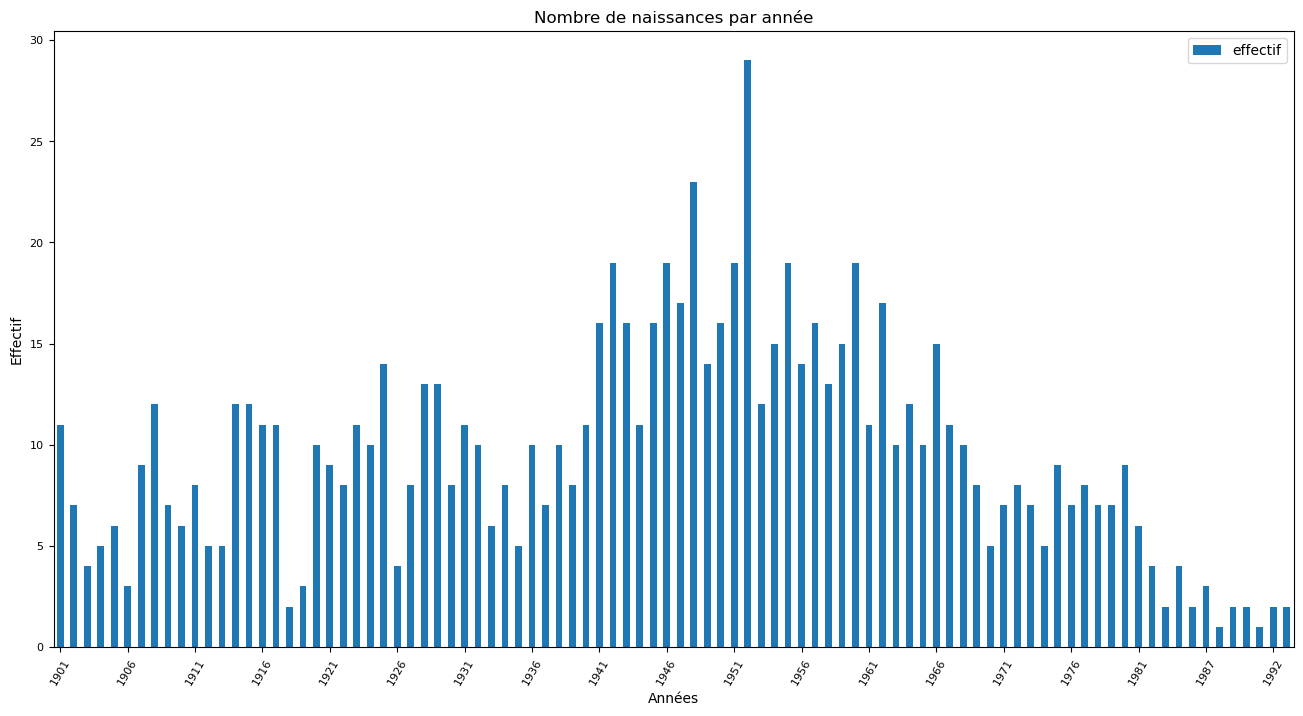

In [23]:
### Représentation graphique des effectifs par année

ax = years_count.plot(x='year', y='effectif', kind='bar',rot=60, fontsize=8, figsize=(16,8))


max_xticks = 20
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Nombre de naissances par année')
plt.show()

## Regrouper les effectifs par périodes de 25 ans

In [24]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_p = df_p[df_p['annee_naissance'] < 2001].copy(deep=True)

In [25]:
cdf_p.head(3)

,personne_uri,nom_prenom,genre_uri,annee_naissance,genre_code
id,,,,,
0,http://www.wikidata.org/entity/Q120229,Robert Tobler,http://www.wikidata.org/entity/Q6581097,1901,M
6,http://www.wikidata.org/entity/Q1579473,Hans Fischer,http://www.wikidata.org/entity/Q6581097,1901,M
7,http://www.wikidata.org/entity/Q1447990,Franz Landolt,http://www.wikidata.org/entity/Q6581097,1901,M


In [26]:
### Année minimale et maximale dans la population
min(cdf_p['annee_naissance']), max(cdf_p['annee_naissance'])

(1901, 1994)

### Codage par période de vingt-cinq ans

In [27]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1900, 1997, 25))
l_25[:5],l_25[-5:]

([1900, 1925, 1950, 1975], [1900, 1925, 1950, 1975])

In [28]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['annee_naissance'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,personne_uri,nom_prenom,genre_uri,annee_naissance,genre_code,periodes
id,,,,,,
0,http://www.wikidata.org/entity/Q120229,Robert Tobler,http://www.wikidata.org/entity/Q6581097,1901,M,1900-1924
6,http://www.wikidata.org/entity/Q1579473,Hans Fischer,http://www.wikidata.org/entity/Q6581097,1901,M,1900-1924
7,http://www.wikidata.org/entity/Q1447990,Franz Landolt,http://www.wikidata.org/entity/Q6581097,1901,M,1900-1924


In [29]:
cdf_p[cdf_p.annee_naissance == 2000][:3]

,personne_uri,nom_prenom,genre_uri,annee_naissance,genre_code,periodes
id,,,,,,


In [30]:
### compter les naissances par périodes de 25 ans
cdf_p.groupby(by='periodes').size()

C:\Users\LZender\AppData\Local\Temp\ipykernel_31432\3799892700.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdf_p.groupby(by='periodes').size()


periodes
1900-1924    187
1925-1949    297
1950-1974    323
dtype: int64

C:\Users\LZender\AppData\Local\Temp\ipykernel_31432\2243886712.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = cdf_p.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))


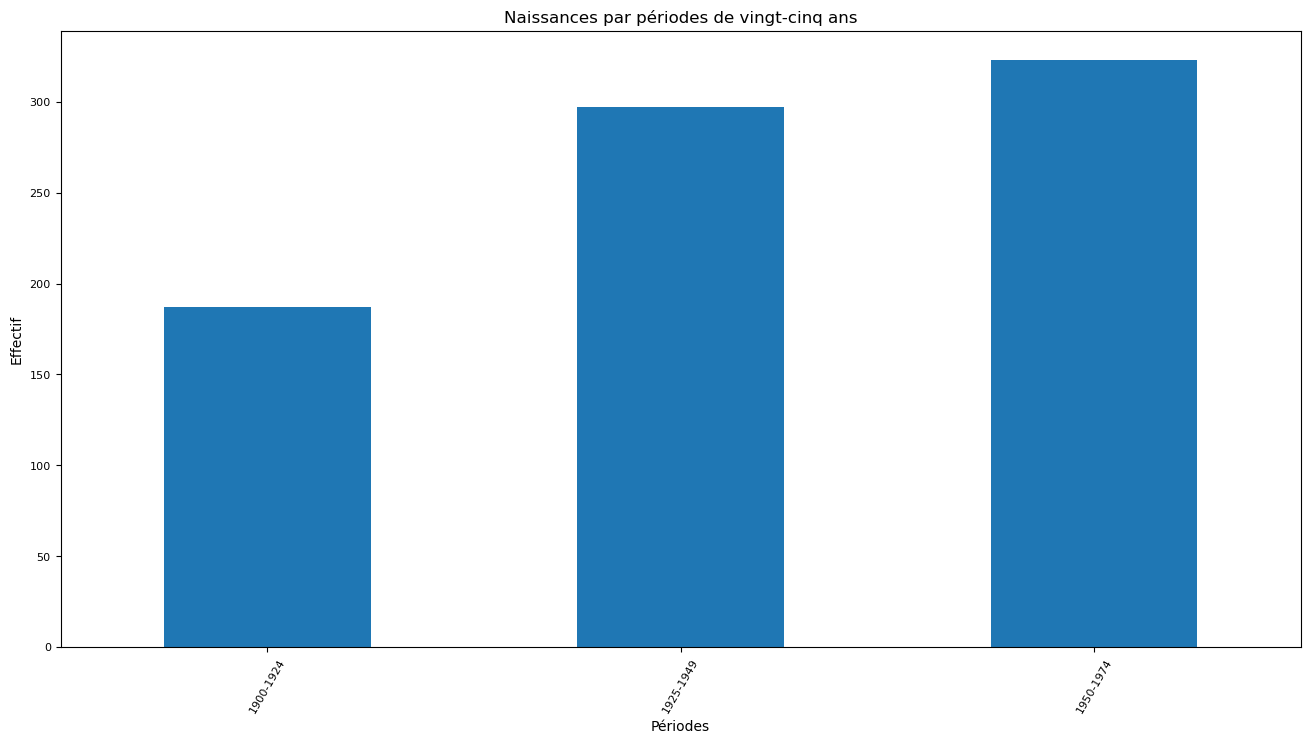

In [31]:
ax = cdf_p.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de vingt-cinq ans')

## On peut enregistrer l'image dans un fichier (noter le dossier créé préalablement)
# qu'on pourra ensuite introduire dans un travail et commenter

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/naissances_distribution_25ans.jpg', bbox_inches='tight',
                       pad_inches=0.2)
plt.show()

## Ajouter la représentation des genres

In [32]:
### Regrouper et compter avec un fitre sur le genre masculin
gender_m = pd.DataFrame(cdf_p[cdf_p.genre_code == 'M'].groupby('periodes').size())
gender_m.columns = ['gen_m']
gender_m.tail()


C:\Users\LZender\AppData\Local\Temp\ipykernel_31432\2602272639.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_m = pd.DataFrame(cdf_p[cdf_p.genre_code == 'M'].groupby('periodes').size())


,gen_m
periodes,
1900-1924,181
1925-1949,239
1950-1974,223


In [33]:
### Regrouper et compter avec un fitre sur le genre féminin
gender_f = pd.DataFrame(cdf_p[cdf_p.genre_code == 'F'].groupby('periodes').size())
gender_f.columns = ['gen_f']
gender_f.tail()


C:\Users\LZender\AppData\Local\Temp\ipykernel_31432\2465417600.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_f = pd.DataFrame(cdf_p[cdf_p.genre_code == 'F'].groupby('periodes').size())


,gen_f
periodes,
1900-1924,6
1925-1949,58
1950-1974,100


In [34]:
### Fusionner les deux tableaux en utilisant l'index comme clé de jointure
merged = pd.merge(gender_m, gender_f, left_index=True, right_index=True)
merged.tail()

,gen_m,gen_f
periodes,,
1900-1924,181,6
1925-1949,239,58
1950-1974,223,100


In [35]:
### Transformer l'index de séquence à chaîne de caractères
# ce qui est indispensable pour l'affichage dans un graphique
merged.index = merged.index.map(str)
merged.tail()

,gen_m,gen_f
periodes,,
1900-1924,181,6
1925-1949,239,58
1950-1974,223,100


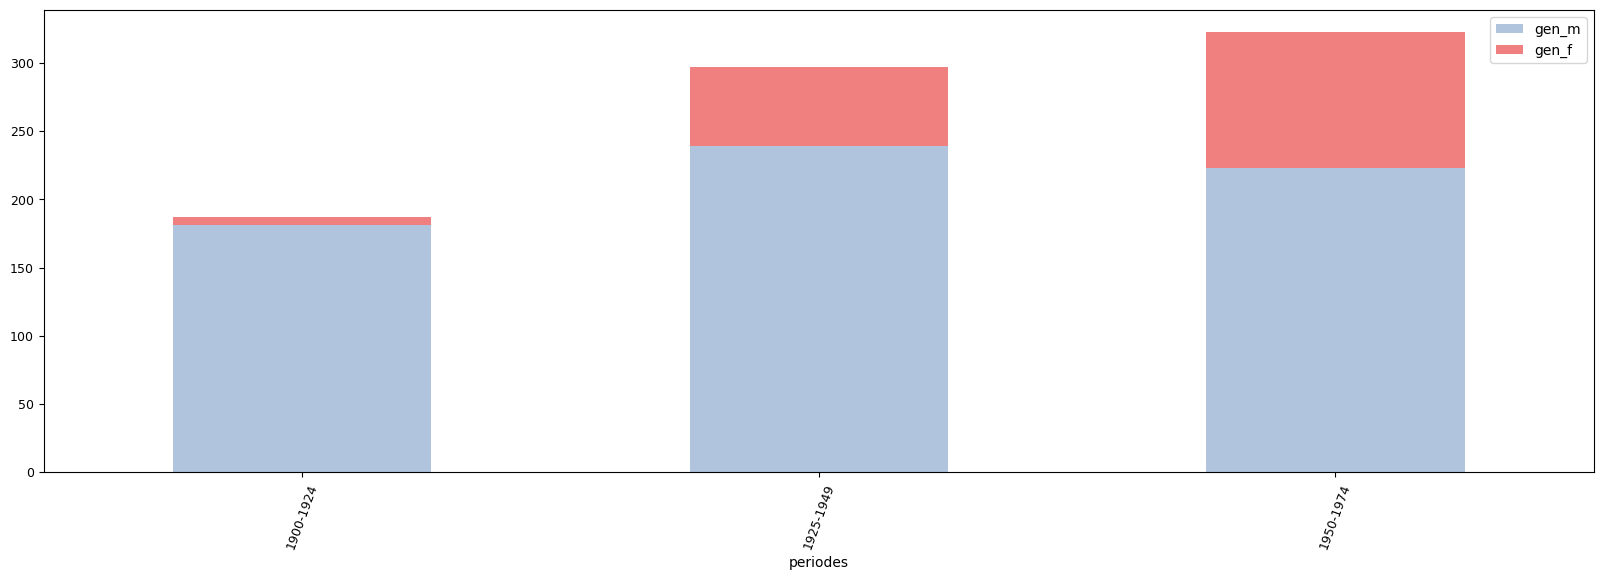

In [36]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,6), color=['LightSteelBlue', 'LightCoral'])
plt.show()

### Codage par période de dix ans

Comme on voit bien dans le graphique précédent qu'il y a deux périodes avec des effectifs radicalements différents, 
on restraint la période analysée à l'époque contemporaine et on affine avec un découpage par périodes de dix ans 

In [37]:
l_10 = list(range(1900, 1997, 10))
l_10[:5],l_10[-5:]

([1900, 1910, 1920, 1930, 1940], [1950, 1960, 1970, 1980, 1990])

In [38]:
### Découpage par décennies
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

cdf_p['per_10'] = pd.cut(cdf_p['annee_naissance'], l_10, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['per_10'] = cdf_p['per_10'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,personne_uri,nom_prenom,genre_uri,annee_naissance,genre_code,periodes,per_10
id,,,,,,,
0,http://www.wikidata.org/entity/Q120229,Robert Tobler,http://www.wikidata.org/entity/Q6581097,1901,M,1900-1924,1900-1909
6,http://www.wikidata.org/entity/Q1579473,Hans Fischer,http://www.wikidata.org/entity/Q6581097,1901,M,1900-1924,1900-1909
7,http://www.wikidata.org/entity/Q1447990,Franz Landolt,http://www.wikidata.org/entity/Q6581097,1901,M,1900-1924,1900-1909


In [39]:
### On regroupe par genre comme ci-dessus
gender_m_10 = pd.DataFrame(cdf_p[(cdf_p.genre_code == 'M') & (cdf_p.annee_naissance > 1850)].groupby('per_10').size())
gender_m_10.columns = ['gen_m']
gender_m_10.tail()


C:\Users\LZender\AppData\Local\Temp\ipykernel_31432\742788011.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_m_10 = pd.DataFrame(cdf_p[(cdf_p.genre_code == 'M') & (cdf_p.annee_naissance > 1850)].groupby('per_10').size())


,gen_m
per_10,
1940-1949,128
1950-1959,117
1960-1969,87
1970-1979,36
1980-1989,21


In [40]:
### Idem
gender_f_10 = pd.DataFrame(cdf_p[(cdf_p.genre_code == 'F')& (cdf_p.annee_naissance > 1900)].groupby('per_10').size())
gender_f_10.columns = ['gen_f']
gender_f_10.tail()


C:\Users\LZender\AppData\Local\Temp\ipykernel_31432\2142987170.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_f_10 = pd.DataFrame(cdf_p[(cdf_p.genre_code == 'F')& (cdf_p.annee_naissance > 1900)].groupby('per_10').size())


,gen_f
per_10,
1940-1949,34
1950-1959,51
1960-1969,36
1970-1979,34
1980-1989,12


In [41]:
merged_10 = pd.merge(gender_m_10, gender_f_10, left_index=True, right_index=True)
merged_10.tail()

,gen_m,gen_f
per_10,,
1940-1949,128,34
1950-1959,117,51
1960-1969,87,36
1970-1979,36,34
1980-1989,21,12


In [42]:
### On transforme le type de valeur de l'index
# et on ajoute une colonne avec le total
merged_10.index = merged_10.index.map(str)
merged_10['tot']=merged_10['gen_m']+merged_10['gen_f']
merged_10.tail()

,gen_m,gen_f,tot
per_10,,,
1940-1949,128,34,162
1950-1959,117,51,168
1960-1969,87,36,123
1970-1979,36,34,70
1980-1989,21,12,33


In [43]:
### On prépare les valeurs pour l'affichage des fréquences (proportion par rapport au total)

# liste qui contient toutes les valeurs à la suite
m_f = merged_10.gen_m.to_list()+merged_10.gen_f.to_list()

# liste d'égale longueur que la précédente qui contient 
# les valeurs de l'index, i.e. les périodes
tot = merged_10.tot.to_list()*2

# liste qui contient les valeurs des fréquences
lp = [round(v/t, 2) for v,t in zip(m_f, tot)]
lp[:3]

[1.0, 0.97, 0.91]

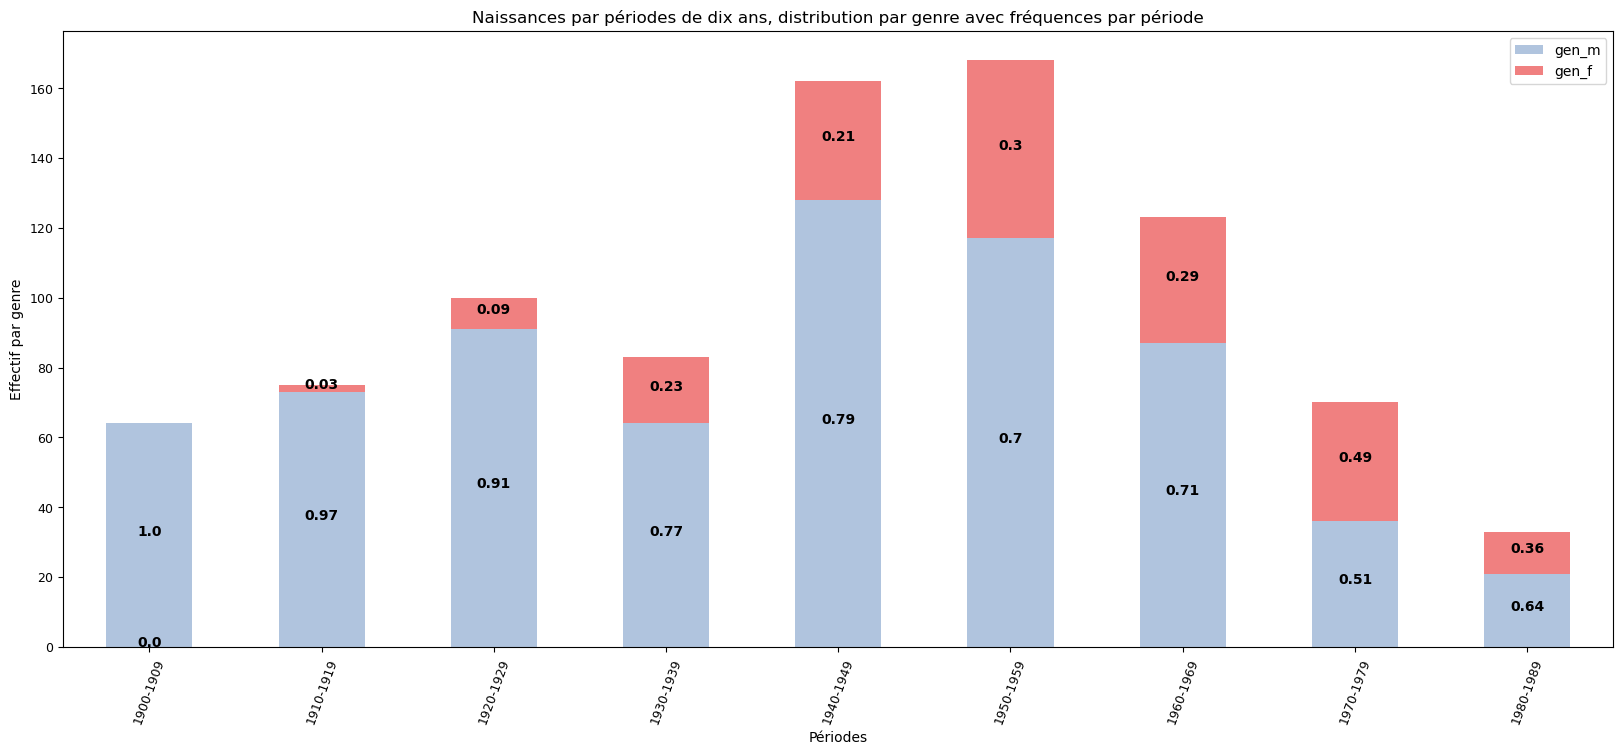

In [44]:
### Graphique avec la distribution par période et genre (M,F)
# Noter que les effectifs du genre 'Autres' étant très faibles,
# on ne les analyse pas de manière sérielle mais on peut les analyser qualitatiement

ax = merged_10.plot.bar(stacked=True, y=['gen_m', 'gen_f'], \
                        rot=70, fontsize=9, figsize=(20,8), color=['LightSteelBlue', 'LightCoral'])


### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/


## On ajoute une étiquette concernant la valeur de fréquence
# à chaque rectangle dans le graphe, en utilisant la list 'lp' préparée précédemment
# Il y a autant de triangles que les valeurs d'index x le nombre de variables

for bar,v in zip(ax.patches,lp): 

    ax.text(
      # Met les étiquette aux centre des rectangles
      bar.get_x() + bar.get_width() / 2,
        
      # Ajoute les coordonnées verticales
      bar.get_height()/2 + bar.get_y(), 
      
      # Ajoute les valeurs
      v,

      # centre et met du style aux étiquettes
      ha='center',
      color='black',
      weight='bold',
      size=10
  )

plt.ylabel('Effectif par genre')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de dix ans, distribution par genre avec fréquences par période')

## On peut enregistrer l'image dans un fichier (noter le dossier créé préalablement)
# qu'on pourra ensuite introduire dans un travail et commenter

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/naissances_distribution_10ans_genre.jpg', bbox_inches='tight',
                       pad_inches=0.2)
plt.show()

### distribution selon les périodes prédéfinies

In [45]:
## les périodes sont définies dans le github et se basent sur des changements majeurs du 20e siècle
l_per = [1901, 1915, 1930, 1946, 1976, 1997]

In [46]:
### Découpage par périodes
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

cdf_p['periodes'] = pd.cut(cdf_p['annee_naissance'], l_per, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,personne_uri,nom_prenom,genre_uri,annee_naissance,genre_code,periodes,per_10
id,,,,,,,
0,http://www.wikidata.org/entity/Q120229,Robert Tobler,http://www.wikidata.org/entity/Q6581097,1901,M,1901-1914,1900-1909
6,http://www.wikidata.org/entity/Q1579473,Hans Fischer,http://www.wikidata.org/entity/Q6581097,1901,M,1901-1914,1900-1909
7,http://www.wikidata.org/entity/Q1447990,Franz Landolt,http://www.wikidata.org/entity/Q6581097,1901,M,1901-1914,1900-1909


In [47]:
### On regroupe par genre comme ci-dessus
gender_m_per = pd.DataFrame(cdf_p[(cdf_p.genre_code == 'M') & (cdf_p.annee_naissance > 1850)].groupby('periodes').size())
gender_m_per.columns = ['gen_m']
gender_m_per.tail()

C:\Users\LZender\AppData\Local\Temp\ipykernel_31432\402658947.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_m_per = pd.DataFrame(cdf_p[(cdf_p.genre_code == 'M') & (cdf_p.annee_naissance > 1850)].groupby('periodes').size())


,gen_m
periodes,
1901-1914,99
1915-1929,129
1930-1945,139
1946-1975,281
1976-1996,36


In [48]:
### Idem
gender_f_per = pd.DataFrame(cdf_p[(cdf_p.genre_code == 'F')& (cdf_p.annee_naissance > 1900)].groupby('periodes').size())
gender_f_per.columns = ['gen_f']
gender_f_per.tail()

C:\Users\LZender\AppData\Local\Temp\ipykernel_31432\3359604365.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_f_per = pd.DataFrame(cdf_p[(cdf_p.genre_code == 'F')& (cdf_p.annee_naissance > 1900)].groupby('periodes').size())


,gen_f
periodes,
1901-1914,1
1915-1929,10
1930-1945,33
1946-1975,124
1976-1996,33


In [49]:
merged_per = pd.merge(gender_m_per, gender_f_per, left_index=True, right_index=True)
merged_per.tail()

,gen_m,gen_f
periodes,,
1901-1914,99,1
1915-1929,129,10
1930-1945,139,33
1946-1975,281,124
1976-1996,36,33


In [50]:
### On transforme le type de valeur de l'index
# et on ajoute une colonne avec le total
merged_per.index = merged_per.index.map(str)
merged_per['tot']=merged_per['gen_m']+merged_per['gen_f']
merged_per.tail()

,gen_m,gen_f,tot
periodes,,,
1901-1914,99,1,100
1915-1929,129,10,139
1930-1945,139,33,172
1946-1975,281,124,405
1976-1996,36,33,69


In [51]:
### On prépare les valeurs pour l'affichage des fréquences (proportion par rapport au total)

# liste qui contient toutes les valeurs à la suite
m_f = merged_per.gen_m.to_list()+merged_per.gen_f.to_list()

# liste d'égale longueur que la précédente qui contient 
# les valeurs de l'index, i.e. les périodes
tot = merged_per.tot.to_list()*2

# liste qui contient les valeurs des fréquences
lper = [round(v/t, 2) for v,t in zip(m_f, tot)]
lper[:3]

[0.99, 0.93, 0.81]

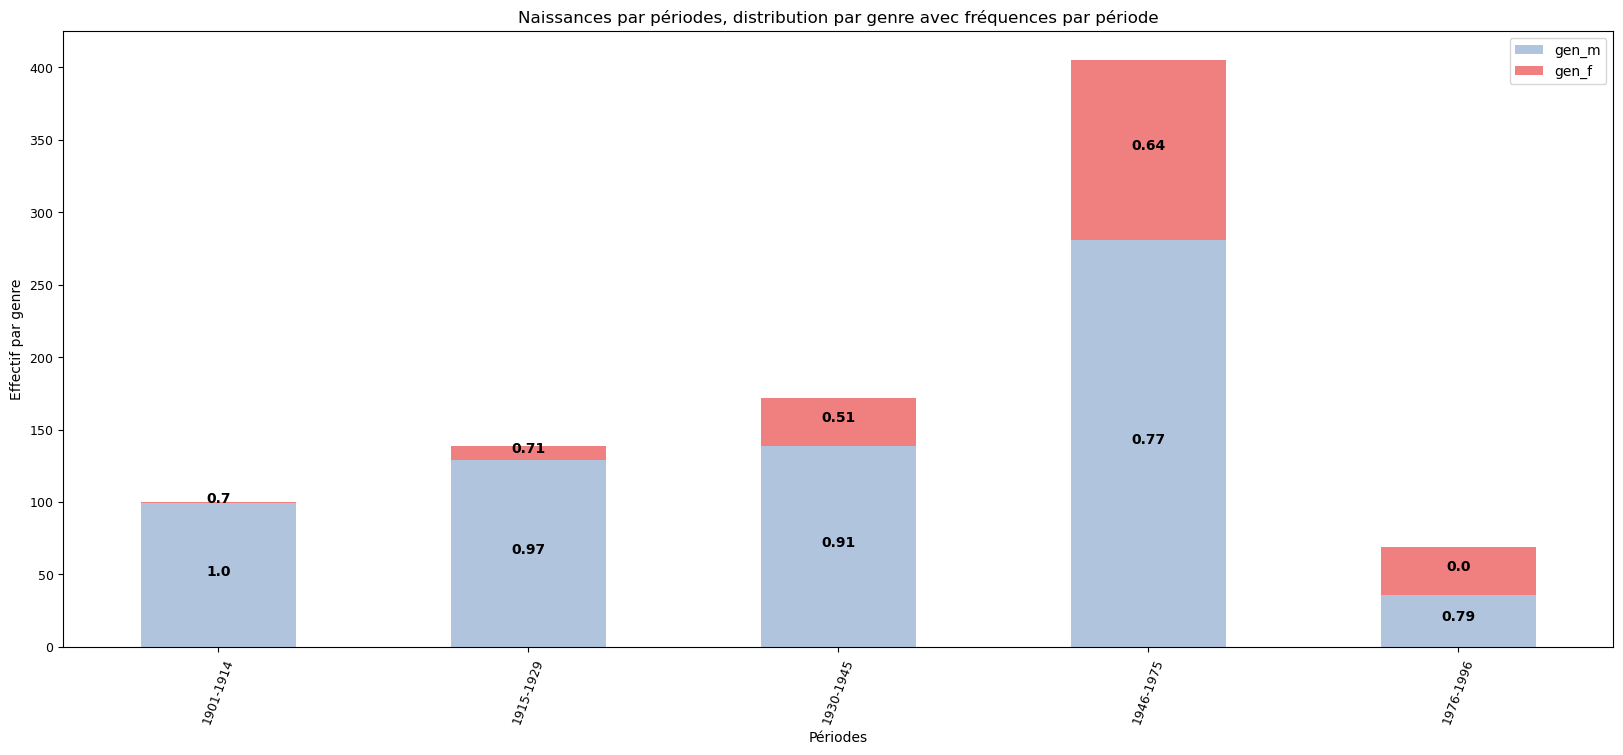

In [52]:
### Graphique avec la distribution par période et genre (M,F)
# Noter que les effectifs du genre 'Autres' étant très faibles,
# on ne les analyse pas de manière sérielle mais on peut les analyser qualitatiement

ax = merged_per.plot.bar(stacked=True, y=['gen_m', 'gen_f'], \
                        rot=70, fontsize=9, figsize=(20,8), color=['LightSteelBlue', 'LightCoral'])


### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/


## On ajoute une étiquette concernant la valeur de fréquence
# à chaque rectangle dans le graphe, en utilisant la list 'lp' préparée précédemment
# Il y a autant de triangles que les valeurs d'index x le nombre de variables

for bar,v in zip(ax.patches,lp): 

    ax.text(
      # Met les étiquette aux centre des rectangles
      bar.get_x() + bar.get_width() / 2,
        
      # Ajoute les coordonnées verticales
      bar.get_height()/2 + bar.get_y(), 
      
      # Ajoute les valeurs
      v,

      # centre et met du style aux étiquettes
      ha='center',
      color='black',
      weight='bold',
      size=10
  )

plt.ylabel('Effectif par genre')
plt.xlabel('Périodes')
plt.title('Naissances par périodes, distribution par genre avec fréquences par période')

## On peut enregistrer l'image dans un fichier (noter le dossier créé préalablement)
# qu'on pourra ensuite introduire dans un travail et commenter

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/naissances_distribution_périodes_genre.jpg', bbox_inches='tight',
                       pad_inches=0.2)
plt.show()